# Laboratorio 2
### Martín Didyk, Arturo Lazcano, Matías Vera

---
## Pregunta 1: Reducción de Varianza

Considere la cantidad 

$$\alpha= \mathbb{E}[e^{bZ}\mathbb{1}_{Z>0}]$$

Donde $Z$ es una variable normal estandar y $b \in \mathbb{R}$ es una constante. Supondremos para este problema que la normal estándar es la única variable eficientemente simulable. Se desea aproximar $\alpha$ mediante un algoritmo de Monte-Carlo con baja varianza.

Para lo que viene se considera $Z\sim \mathcal{N}(0,1)$, además  $(Z_k)_{k\geq 1}$ i.i.d., tal que $\forall k\geq 1$, $Z_k \sim \mathcal{N}(0,1) $

**1-** Proponga un método de muestreo preferencial.

Se tiene que $f(x)\mu(dx) = A \cdot exp(-1/2(x^2-bx))\cdot\mathbb{1}_{Z>0}  dx$, es decir que los valores con mayor peso están alrededor de $x=b$, con lo cual se propone $\nu(dx)\sim exp(-1/2 (x-b)^2)dx$. Con esto:

$$\nu(dx)=\dfrac{1}{\sqrt{2\pi}}e^{-\dfrac{1}{2}(x-b)^2}dx=\underbrace{e^{bx -\dfrac{1}{2}b^2} }_{L(x)} \cdot \underbrace{\dfrac{1}{\sqrt{2\pi}}e^{-\dfrac{1}{2}x^2}dx}_{\mu(dx)}=L(x)\mu(dx)$$

Con esto tenemos el $L(x)$ para ocupar el método de muestreo preferencial.

$$\dfrac{f(Z)}{L(Z)}=\dfrac{e^{bZ}\cdot \mathcal{1}_{Z>0}}{e^{bZ-(1/2)b^2}}=e^{(1/2)b^2}\cdot \mathbb{1}_{Z>0}$$

Con esto:

$$\mathbb{E}[\dfrac{f(Z)}{L(Z)}] = \mathbb{E}[e^{bZ}\mathbb{1}_{Z>0}] $$

**2-** Sabiendo que $\mathbb{E}[e^{bZ}]=e^{b^2/2}$, proponga un método de variable de control.

Ya que $e^{bZ}\mathbb{1}_{Z>0}=f(Z)$ y si se toma $h(Z)=e^{bZ}$ entonces se conoce $\mathbb{E}[h(Z)]$, con lo cual es posible utilizar el método de variable de control con:

$$\varphi(Z)=f(Z)-c \cdot (e^{bZ} - e^{b^2/2})$$

Con $c$ a determinar. Con esto:

$$\dfrac{1}{n} \sum_{k=1}^n \varphi(Z_k) \to \mathbb{E}[e^{bZ}\mathbb{1}_{Z>0}] $$

**3-** Mejore el método del item anterior usando una variable antitética.

Para utilizar el método de varible antitética se notará que si $Z \sim \mathcal{N}(0,1) \implies (-Z) \sim \mathcal{N}(0,1)$. Con lo cual:

$$\dfrac{1}{2n}  \sum_{k=1}^n (f(Z_k)+f(-Z_k)) \to \mathbb{E}[e^{bZ}\mathbb{1}_{Z>0}] $$

pero como lo que se quiere es mejorar el modelo anterior, en vez de tomar $f(Z)$, se utilizará $\varphi(Z)$, con lo que:

$$\mathbb{E}[\dfrac{\varphi(Z)+\varphi(-Z)}{2}] = \mathbb{E}[e^{bZ}\mathbb{1}_{Z>0}]$$

In [1]:
import math as m
import numpy as np
import seaborn as sb
import time
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random as r
import scipy
import scipy.stats as ss
np.random.seed(19680801)

Se dispondrá de cuatro métodos de Monte Carlo para aproximar $\alpha$: aplicando en la definición y usando los 3 modelos propuestos. En lo que sigue, se trabajará con $b=2$

4- Aproximar numéricamente la raiz de la varianza de la variable aleatoria que da lugar a cada uno de los cuatro métodos, para distintos tamaños de muestras y graficar. Obtener una estimación de la raiz de la varianza en cada caso.

In [2]:
def metodo0(b,N):
    a=np.random.normal(0,1,N)
    B=np.zeros(N)
    for i in range(N):
        if a[i]>0:
            B[i]=m.exp(b*a[i])
    return B

def metodo1(b,N):
    a=np.random.normal(0,1,N)
    for i in range(N):
        a[i]=a[i]+b
    #Traslada la normal a b
    B=np.zeros(N)
    c=m.exp((1/2)*b**2)
    for i in range(N):
        if a[i]>0:
            B[i]=c
    return B

def metodo2(b,c,N):
    a=np.random.normal(0,1,N)
    B=np.zeros(N)
    d=m.exp((b**2)/2)
    for i in range(N):
        if a[i]>0:
            B[i]=m.exp(b*a[i])-c*(m.exp(b*a[i])-d)
        else:
            B[i]=-c*(m.exp(b*a[i])-d)
    return B

def metodo3(b,c,N):
    a=np.random.normal(0,1,N)
    e=np.zeros(N)
    for i in range(N):
        e[i]=-a[i]
    B=np.zeros(N)
    d=m.exp((b**2)/2)
    for i in range(N):
        if a[i]>0:
            B[i]=(m.exp(b*a[i])-c*(m.exp(b*a[i])-d)+m.exp(b*e[i])-c*(m.exp(b*e[i])-d))/2
        else:
            B[i]=((-c)*(m.exp(b*a[i])-d)-c*(m.exp(b*a[i])-d))/2
    return B

Notamos que para que el modelo esté correcto hace falta encontrar $c$, ahora, se sabe que se puede aproximar $c$ por:

$$c \approx \dfrac{\sum_{k=1}^q (Y_k - \bar{Y_q})(Z_k - \mathbb{E}[Z_1])}{\sum_{k=1}^q (Z_k - \mathbb{E}[Z_1])^2}$$

Donde $Y_k=f(X_k), Z_k=h(X_k)$. Con esto es posible encontrar una $c$ adecuado cuando $q$ es grande.

In [3]:
def aproximarc(b,N):
    #Simplemente se ocupa la fórmula vista en clases
    a=np.random.normal(0,1,N)
    Zm=m.exp((b**2)/2)
    Y=np.zeros(N)
    Z=np.zeros(N)
    for i in range(N):
        if a[i]>0:
            Y[i]=m.exp(b*a[i])
    Ym=np.mean(Y)
    for i in range(N):
        Z[i]=m.exp(b*a[i])
    Num=0
    Den=0
    for i in range(N):
        Num=Num+(Y[i]-Ym)*(Z[i]-Zm)
        Den=Den+(Z[i]-Zm)**2
    return Num/Den

c=aproximarc(2,10**6)
print(c)

1.0004936248745522


Ya con eso, se aproximar $c \approx 1$ y es posible aproximar las varianzas de cada método.

In [4]:
def raizvarianza(i,b,c,N):
    if i==0:
        A=metodo0(b,N)
    elif i==1:
        A=metodo1(b,N)
    elif i==2:
        A=metodo2(b,c,N)
    elif i==3:
        A=metodo3(b,c,N)
    else:
        print("Modelo no conocido")
    B=np.zeros(N)
    D=0
    Ym=np.mean(A)
    #entrega un vector calculando la std desde 1 a N
    for i in range(N):
        B[i]=((D+(A[i]-Ym)**2)/(i+1))
        D=B[i]*(i+1)
    for i in range(N):
        B[i]=m.sqrt(B[i])
    return B
        

<function matplotlib.pyplot.show(*args, **kw)>

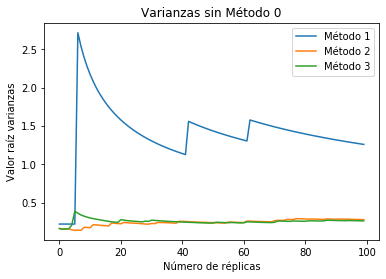

In [5]:

y1=raizvarianza(0,2,1,10**2)
y2=raizvarianza(1,2,1,10**2)
y3=raizvarianza(2,2,1,10**2)
y4=raizvarianza(3,2,1,10**2)
x = np.arange(0, 10**2, 1)
fig, ax = plt.subplots()
#ax.plot(x, y1, label="Método 0")
plt.xlabel('Número de réplicas')
plt.ylabel('Valor raíz varianzas')
plt.title("Varianzas sin Método 0")
ax.plot(x, y2, label="Método 1")
ax.plot(x, y3, label="Método 2")
ax.plot(x, y4, label="Método 3")
ax.legend()
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

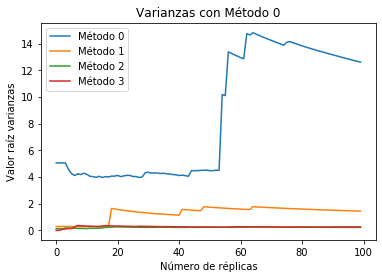

In [6]:

y1=raizvarianza(0,2,1,10**2)
y2=raizvarianza(1,2,1,10**2)
y3=raizvarianza(2,2,1,10**2)
y4=raizvarianza(3,2,1,10**2)
x = np.arange(0, 10**2, 1)
fig, ax = plt.subplots()
plt.xlabel('Número de réplicas')
plt.ylabel('Valor raíz varianzas')
plt.title("Varianzas con Método 0")
ax.plot(x, y1, label="Método 0")
ax.plot(x, y2, label="Método 1")
ax.plot(x, y3, label="Método 2")
ax.plot(x, y4, label="Método 3")
ax.legend()
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

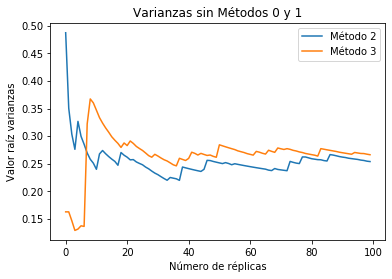

In [7]:
y1=raizvarianza(0,2,1,10**2)
y2=raizvarianza(1,2,1,10**2)
y3=raizvarianza(2,2,1,10**2)
y4=raizvarianza(3,2,1,10**2)
x = np.arange(0, 100, 1)
fig, ax = plt.subplots()
plt.xlabel('Número de réplicas')
plt.ylabel('Valor raíz varianzas')
plt.title("Varianzas sin Métodos 0 y 1")
#x.plot(x, y1, label="Método 0")
#ax.plot(x, y2, label="Método 1")
ax.plot(x, y3, label="Método 2")
ax.plot(x, y4, label="Método 3")
ax.legend()
plt.show


Se nota de estos gráficos que la varianza del método original es muy superior a la de otro modelos, mientras que el método 1 es una mejora sustancial, sin embargo los métodos 2 y 3 son mucho mejores que este. Considerando $N=10^5$, las raices de las varianzas son las siguientes.

In [8]:
A1=metodo0(2,10**5)
A2=metodo1(2,10**5)
A3=metodo2(2,1,10**5)
A4=metodo3(2,1,10**5)
#Se calcula la desviación estandar de 10^5 replicas de los 4 métodos
print( "Raices de varianzas")
print("Método 0: " + str(np.std(A1)))
print("Método 1: " + str(np.std(A2)))
print("Método 2: " + str(np.std(A3)))
print("Método 3: " + str(np.std(A4)))

Raices de varianzas
Método 0: 69.86600390889295
Método 1: 1.0962941508180364
Método 2: 0.25843466235016616
Método 3: 0.25683561157878576


5- Usando la estimación de la raíz de la varianza del punto previo y aproximando con el TCL, calcular el tamaño de la muestra necesario para cada método de modo que el error obtenido sea inferior a $\varepsilon=0.02$ con probabilidad de $95$%. Comente

El TCL entrega que la cantidad de réplicas necesarias está dada por:

$$N_{\text{necesarias}} \geq \dfrac{\sigma^2 \cdot z_{\alpha/2}}{\varepsilon^2} $$

Se tienen todos los datos, así que es posible calcularlos:

In [9]:
N1=(np.var(A1)*(1.96)**2)/(0.02**2)
N2=(np.var(A2)*(1.96)**2)/(0.02**2)
N3=(np.var(A3)*(1.96)**2)/(0.02**2)
N4=(np.var(A4)*(1.96)**2)/(0.02**2)

#Ya que interesan naturales, se utiliza la función techo

N1=m.ceil(N1)
N2=m.ceil(N2)
N3=m.ceil(N3)
N4=m.ceil(N4)
print("Replicas necesarias")
print("Método 0: " + str(N1))

print( "Método 1: " + str(N2))

print( "Método 2: " + str(N3))

print( "Método 3: " + str(N4))

Replicas necesarias
Método 0: 46879607
Método 1: 11543
Método 2: 642
Método 3: 634


Como se puede apreciar, de el método original a los métodos siguientes la mejora es tremenda, sin embargo el método 1 sigue siendo bastante ineficiente en comparación a los 2 y 3.

6- Sea $N_{max}$ el tamaño de muestra máximo entre los calculados en el item anterior para los 3 métodos propuestos (es decir, excluyendo el método 0). Para distintos tamaños crecientes hasta $N_{max}$, obtener la estimación de $\alpha$ de cada uno de los métodos y graficar. 

Con los resultados anteriores, $N_{max}$ es del orden de los $11$k.

In [10]:
def promedios(i, b, c, N):
    if i==0:
        A=metodo0(b,N)
    elif i==1:
        A=metodo1(b,N)
    elif i==2:
        A=metodo2(b,c,N)
    elif i==3:
        A=metodo3(b,c,N)
    B=np.zeros(N)
    D=0
    #Se van haciendo promedios empíricos de 1 a N
    for i in range(N):
        B[i]=(D+A[i])/(i+1)
        D=B[i]*(i+1)
    return B

<function matplotlib.pyplot.show(*args, **kw)>

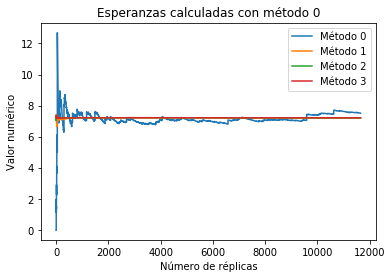

In [11]:
y1=promedios(0,2,1,11648)
y2=promedios(1,2,1,11648)
y3=promedios(2,2,1,11648)
y4=promedios(3,2,1,11648)
x = np.arange(0, 11648, 1)
fig, ax = plt.subplots()
plt.xlabel('Número de réplicas')
plt.ylabel('Valor numérico')
plt.title("Esperanzas calculadas con método 0")
ax.plot(x, y1, label="Método 0")
ax.plot(x, y2, label="Método 1")
ax.plot(x, y3, label="Método 2")
ax.plot(x, y4, label="Método 3")
ax.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

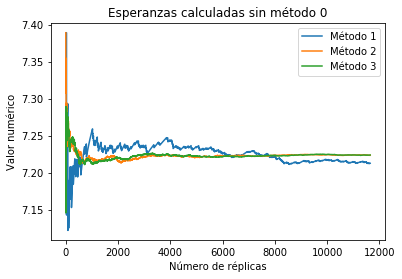

In [12]:
y1=promedios(0,2,1,11648)
y2=promedios(1,2,1,11648)
y3=promedios(2,2,1,11648)
y4=promedios(3,2,1,11648)
x = np.arange(0, 11648, 1)
fig, ax = plt.subplots()
plt.xlabel('Número de réplicas')
plt.ylabel('Valor numérico')
plt.title("Esperanzas calculadas sin método 0")
#ax.plot(x, y1, label="Método 0")
ax.plot(x, y2, label="Método 1")
ax.plot(x, y3, label="Método 2")
ax.plot(x, y4, label="Método 3")
ax.legend()
plt.show

In [13]:
def Esperanzas(b,c,N):
    A1 = metodo0(b,N) 
    a1 = np.mean(A1)
    B1 = metodo1(b,N)
    b1 = np.mean(B1)
    C1 = metodo2(b,c,N)
    c1 = np.mean(C1)
    D1 = metodo3(b,c,N)
    d1 = np.mean(D1)
    R=np.array([[a1],[b1],[c1],[d1]])
    columnas=["Método 0","Método 1","Método 2","Método 3"]
    filas=["Esperanzas"]
    return pd.DataFrame(data=np.transpose(R), index=filas, columns=columnas)

print("Esperanzas calculadas con Nmax")
Esperanzas(2,1,11648)


Esperanzas calculadas con Nmax


,Método 0,Método 1,Método 2,Método 3
Esperanzas,8.266025,7.22095,7.2182,7.227255


7- En base a lo obtenido en los puntos previos, ¿Cual método es el mejor y cual es el peor? Obtener el valor exacto de $\alpha$ usando una herramienta adecuada, y comparar con el valor entregado por los cuatro métodosm usando el mismo $N_{max}$ para todos. Comente

Basta notar que:

$$\alpha = \mathbb{E}[e^{bZ}\cdot \mathbb{1}_{Z>0}]=\int_{0}^\infty e^{bx}\cdot \dfrac{1}{\sqrt{2\pi}} e^{-(1/2)x^2}dx$$

Tomando $b=2$

$$\alpha = \int_{0}^\infty \dfrac{1}{\sqrt{2\pi}}  e^{\dfrac{-1}{2} (x^2-4x)}dx \approx 7.22095$$

según www.wolframalpha.com

Con estos resultados está claro que el peor método de los 3 propuestos es el de muestreo preferencial, ya que necesita muchas réplicas y sin embargo tiene un costo parecido a los otros, en cambio el mejor método está en disputa, ya que si bien el método 3 necesita menos réplicas que el 2, este último necesita menos operaciones, con lo que su costo menor puede compensar las réplicas adicionales, para esto probemos tomando tiempos.

In [14]:
def tiempos(b,c,N):
    Inicio1=time.time()
    metodo2(b,c,N)
    Final1=time.time()
    Inicio2=time.time()
    metodo3(b,c,N)
    Final2=time.time()
    return [Final1-Inicio1, Final2-Inicio2]

print(tiempos(2,1,10**2))
print(tiempos(2,1,10**3))
print(tiempos(2,1,10**4))
print(tiempos(2,1,10**5))
print(tiempos(2,1,10**6))

[0.00045990943908691406, 0.0008950233459472656]
[0.002101898193359375, 0.0034003257751464844]
[0.022370100021362305, 0.03624773025512695]
[0.20765376091003418, 0.3375260829925537]
[1.6531360149383545, 3.4434471130371094]


Con lo cual, al tener el método 2 un costo menor, casi la mitad del método 3, se tiene que el mejor método para calcular $\alpha$ es el método de variable de control sin utilizar variables antitéticas.

Si bien este no es el resultado esperado, ya que la mejora del método 2 debería bajar mucho más la varianza, sin embargo se buscó y no se encontro un error. De existir un error, lo más probable es que sea en la programación del método más que en los cálculos.

---

## Pregunta 2: Cadenas de Markov y Flujos Markovianos
El objetivo de esta pregunta es hacer una simulación de cadenas de Markov y flujos Markovianos.

---

### **1.** 
Sea $P$ una matriz estocástica indexada por $E$. Si $f$ es tal que $\mathbb{P}(f(x,U) = y) = P_{xy}$ para todo $x,y \in E$, diremos que es una función de transición asociada a la matriz $P$. Muestre que $f(x,u) := \inf\{y \in E : \sum_{z=1}^y P_{xz} \geq u\}$ cumple esa condición, y que la cadena $(X_n)_{n\in\mathbb{N}}$ así construida tiene entonces matriz de transición $P$.

Note que dada una v.a. uniforme $U$ en $[0, 1]$, $\phi:= f (\cdot, U ) : E \rightarrow E$ es una función aleatoria, que entrega transiciones de la cadena desde un estado $x$ cualquiera, a algún estado $y = \phi(x) = f (x, U)$.

---
**Objetivo:** Probar que la función dada es efectivamente una función de transición, lo que será útil para simular cadenas de Markov de una forma equivalente.

---

Para ver que $f$ es función de transición calculemos $\mathbb{P}(f(x,U)=y)$.
$$\begin{align*}
\mathbb{P}(f(x,U)=y) &= \mathbb{P}(\inf\{w\in E: \sum_{z=1}^wP_{xz}\geq u\}=y)\\
&= \mathbb{P}(\sum_{z=1}^{y-1}P_{xz}< u , \sum_{z=1}^yP_{xz}\geq u)\\
&= \mathbb{P}(\sum_{z=1}^{y-1}P_{xz}< u \leq \sum_{z=1}^yP_{xz})\\
&= \sum_{z=1}^yP_{xz} - \sum_{z=1}^{y-1}P_{xz}\\
&= P_{xy}
\end{align*}$$
Además, notemos que $\mathbb{P}(X_{n+1}=y | X_n = x) = \mathbb{P}(f(x,U)=y) = P_{xy}$.

Con esto podemos decir que efectivamente $f$ es función de transición asociada a $P$, y que la cadena $(X_n)_{n\in\mathbb{N}}$ construida de esa forma tiene matriz de transición $P$.

---

### 2. 
Programe una función `Trans(x,u,P)` que tiene como parámetros un valor $u$ en $[0, 1]$ y una matriz estocástica $P$ indexada por $\{1,...,N\}$, y entrega para cada $x$ el valor correspondiente de la función de transición asociada a $P$ con el parámetro $u$ dado. Puede usar para ello una función ya programada en el Laboratorio 1 si lo desea.
En base a lo anterior, construya también un método `CM(mu,P,n)` que simule $n$ pasos de la cadena de Markov homogénea con matriz de transición $P$ y distribución inicial $mu$.

---
**Objetivo:** Programar la función de transición definida arriba, que luego nos servirá para simular cada paso de una cadena de Markov con cierta matriz de transición. Luego programar una función que simule una cadena en n pasos, para cierta distribución inicial y matriz de transición dadas.

---

In [15]:
def Trans(x,u,P):
    j = 0 
    F = 0 
    while u>F: 
        F += P[x-1, j]
        j += 1
    return j

In [16]:
def CM(mu, P, n):
    u = np.random.uniform(size=n) #muestra iid de n uniformes
    
    #a partir de la distribucion inicial mu, determinamos x_0
    j = 0
    F = 0
    while u[0]>F:
        F += mu[j]
        j += 1
    x_0 = j
    
    cm = [x_0] #iniciamos la cadena
    x_n = x_0 #estado inicial
    
    #programamos la transición de la cadena, con el uso de la función Trans
    for k in range(n):
        y = Trans(x_n, u[k], P)
        cm.append(y)
        x_n = y
    
    return np.array(cm) #retorna un arreglo con la cadena en n pasos

---
### **3.**
Notar ahora que dadas realizaciones $(U_n)_{n\geq1}$ de v.a. i.i.d. uniformes en $[0, 1]$, disponemos de una sucesión de funciones (aleatorias) $\phi_n := f(\cdot,U_n) : E \rightarrow E$, con $n \geq 1$, que entregan transiciones de la cadena desde un estado $x$ cualquiera en el tiempo $n − 1$, a algún estado $y = \phi_n(x) = f(x,U_n)$ en el tiempo $n$.

Más aun, disponemos de un flujo aleatorio $(\phi_{n,m}:E\rightarrow E)_{n\geq0, m>n}$ dado por $\phi_{n,m}(x) = \phi_m\circ ... \circ\phi_n(x)$, que puede entregar las transiciones de la cadena desde cualquier estado $x$ en el tiempo $n − 1$, a algún estado $y = \phi_{n,m}(x)$ en el tiempo $m$.

En base a la función construida en la parte 1), construya ahora una función `Flujo(x,n,m,u,P)` que toma como parámetros un vector $u$ de $m − n + 1$ valores en $[0, 1]$ y una matriz estocástica $P$, y entrega para cualquier $x$ , el estado en el tiempo $m$ de una cadena que se encuentra en $x$ en el tiempo $n − 1$ obtenido al hacer $m − n + 1$ transiciones sucesivas con la función de transición asociada a $P$.

---
**Objetivo:** Programar una función que simule el flujo markoviano, o sea el estado al que llega la cadena en un tiempo m, partiendo desde el estado x a tiempo n.

---

Para calcular el flujo hacemos uso de la propiedad de Markov para la cadena $(X_n)_{n\in\mathbb{N}}$, ya que no es necesario simular los $m$ pasos de esta, sino sólo los $n-m$ restantes desde el estado a tiempo $n$. Como no necesitamos la cadena completa sino sólo el estado a tiempo $m$, usaremos la función `Trans` en vez de la simulación vía `CM`.

In [17]:
def Flujo(x,n,m,u,P):
    x_k = x
    y = 0
    for k in range(m-n):
        y = Trans(x_n, u[k], P)
        x_k = y
    return y

---
### **4.**
Usando las funciones antes construidas, y utilizando (solo) $n = 100$ v.a. uniformes, simule y grafique $n = 100$ pasos de $K = 10$ trayectorias de un paseo aleatorio en el conjunto $\{1, ..., N\}$ para $N = 10$, donde cada trayectoria parte de un estado distinto. En los extremos $x = 1, 10$ el paseo aleatorio se queda en el estado actual con probabilidad $1 − p$ y salta con probabilidad $p$. Realice esto en cada uno de los 3 casos siguientes: $p = 1/2$, $p = 1/3$, $p = 2/3$.

---
**Objetivo:** Hacer una simulación real de una cadena de Markov, con espacio de estados 1,...,10, en n=100 pasos. Esto nos ayudará a comprender el comportamiento de una cadena de Markov con respecto a su matriz de transición.

---

Primero definamos una función auxiliar que nos ayudará a armar la matriz de transición para las distintas configuraciones.

In [18]:
def matrix(p, N):
    P = np.zeros([N,N])
    P[0][0] = 1.-p
    P[0][1] = p
    P[N-1][N-1] = 1.-p
    P[N-1][N-2] = p
    for i in range(1,N-1):
        for j in range(N):
            if j==i+1 or j==i-1:
                P[i,j] = 1/2
    return P

Luego definiremos una función que simulará una cadena de Markov de $n$ pasos para una matriz de transición $P$, una muestra $u$ de $n$ uniformes en $[0,1]$ iid, y un estado inicial $x$ (es bastante similar a la función `CM` pero para un estado inicial fijo y una muestra de uniformes fija.

In [19]:
def walk(x, P, n, u):
    cm = [x]
    x_n = x
    
    for k in range(n-1):
        y = Trans(x_n, u[k], P)
        cm.append(y)
        x_n = y
    
    return cm

Finalmente definimos una función que simulará un paseo aleatorio en el conjunto $\{1,...,N\}$, con $N=10$, para $n=100$ pasos, y partiendo de cada estado, en función del parámetro de probabilidad $p$.

In [20]:
N = 10
n = 100
T = np.arange(n)

def simulacionCM(p):
    P = matrix(p, N)
    u = np.random.uniform(size=n-1)
    CM = []
    for i in range(N):
        CM.append(walk(i+1, P, n, u))
    return np.array(CM)

Ahora hacemos las simulaciones para $p=1/2, p=1/3, p=2/3$ y graficamos los resultados.

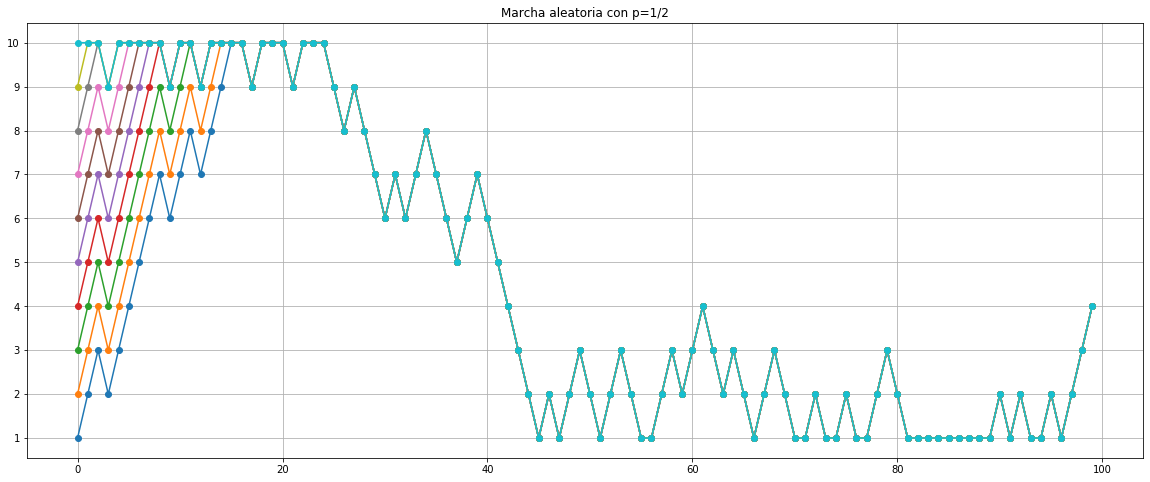

In [21]:
# p=1/2
CM_p_12 = simulacionCM(1/2)
plt.figure(figsize=(20,8))
for cm in CM_p_12:
    plt.plot(T,cm, 'o-')
plt.title('Marcha aleatoria con p=1/2')
plt.yticks(np.arange(N)+1)
plt.grid()
plt.show()

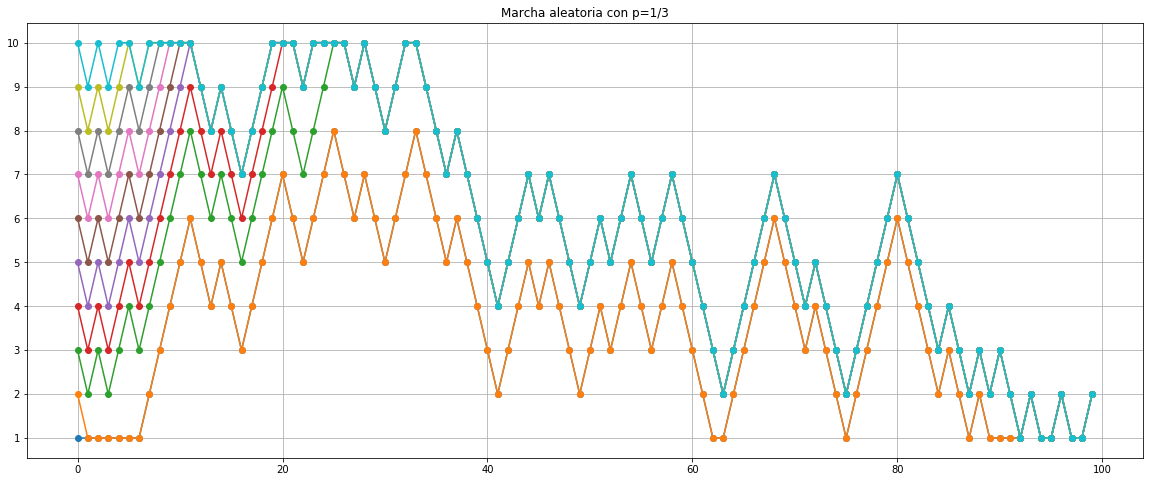

In [22]:
# p=1/3
CM_p_13 = simulacionCM(1/3)
plt.figure(figsize=(20,8))
for cm in CM_p_13:
    plt.plot(T,cm, 'o-')
plt.title('Marcha aleatoria con p=1/3')
plt.yticks(np.arange(N)+1)
plt.grid()
plt.show()

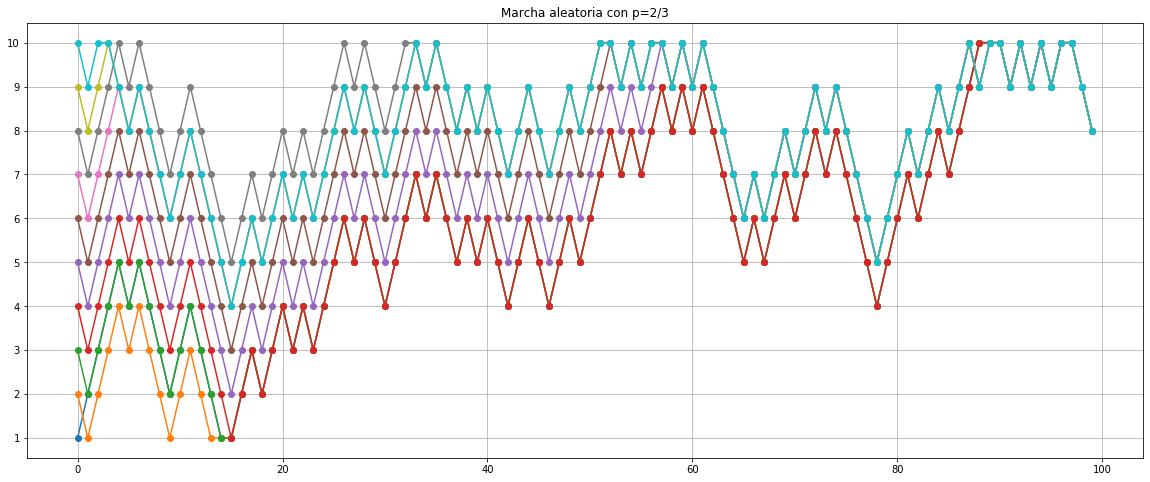

In [23]:
# p=2/3
CM_p_23 = simulacionCM(2/3)
plt.figure(figsize=(20,8))
for cm in CM_p_23:
    plt.plot(T,cm, 'o-')
plt.title('Marcha aleatoria con p=2/3')
plt.yticks(np.arange(N)+1)
plt.grid(which='both')
plt.show()

En vista de los tres modelos anteriores, podemos ver que las cadenas parten en estados distintos y van convergiendo todas hacia una misma cadena, lo que nos hace pensar que hay una distribución invariante bajo este proceso. Al ser un paseo aleatorio **simétrico**, este proceso se comporta "macroscópicamente" de igual forma mientras se encuentra en los estados "interiores" (que no son ni 1 ni 10), pero el tiempo promedio que se quedan en los estados extremos (1 y 10) cambia cuando se varía el parámetro $p$, ya que mientras menor sea $p$, mayor será el tiempo que la cadena se quede en ese estado limítrofe, como se puede observar en los gráficos donde se ve que para el caso $p=1/3$ la cadena tiende a quedarse más en los extremos, mientras que con $p=2/3$ la cadena sale rápidamente de ellos.

---

## P3: Aplicación a un modelo de colas
### 1.

Para escribir el proceso descrito en el enunciado como función de VA's Bernoulli podemos notar que la expresión  
$X_n=X_{n-1}-Z_n\cdot 1_{X_{n-1}>0}+Y_n$  
cumple lo pedido, observando que la indicatriz es necesaria para el caso en que no hayan personas en la cola.  
Para ver que $(X_n)$ es irreducible veamos que el estado $n=0$ se comunica con todos los otros estados.  
Sea $\tau_i$ el tiempo transcurrido hasta las i personas en la cola, notando que podemos pasar de un estado $j$ a $j+1$ con una probabilidad de p(1-q) (llega un cliente y no se va ninguno), para todo $j \geq 0$. Esto pues las variables $Y_n$ y $Z_n$ son independientes para todo $n$. Entonces,  
$\mathbb{P}_0(\tau_i<\infty) \geq p^i(1-q)^{i-1} > 0$  
Por otro lado, para pasar del estado $j$ al $j-1$, por el mismo razonamiento anterior se tiene que  
$\mathbb{P}_i(\tau_0<\infty) \geq q^i(1-p)^i > 0$  
Por lo que se puede concluír que $0 \leftrightarrow i$ para todo estado $i$, por lo tanto $X_n$ es irreducible.

Como se indica en el problema, los parámetros son $p$ y $q$ por lo que veremos 3 casos:
1. $p > q$
2. $p = q$  
3. $p < q$
       

1. Sabiendo que la cadena $(X_n)$ diverge c.s. para este caso tenemos que $X_n \rightarrow \infty$ c.s. Esto implica que $\mathbb{P}_i(\tau_i<\infty)<1$, lo que equivale a decir que la cadena $(X_n)$ es transiente.
2. En este caso sabemos que la medida invariante es $(1-p,1,1,1,...)$. Fue antes probado que la cadena $(X_n)$ es irreducible, por lo que (salvo multiplicación) esta es la única medida invariante. Por otro lado, esta medida no puede ser normalizada y tampoco suma 1 para ser medida de probabilidad. Así, como no existe medida de probabilidad invariante, pero si medida invariante tenemos que la cadena $(X_n)$ es recurrente nula para el caso $p = q$.
3. Por el mismo argumento anterior, $\pi$ es la única (salvo ponderación) medida invariante. Veamos que es distribución, es decir, suma 1. Sea I el conjunto de estados,  
$\displaystyle \sum_{x\in I} \pi_x = \frac{q-p}{q} + \frac{q-p}{q(1-q)} \cdot \sum_{x=1}^{\infty} \bigg(\frac{p(1-q)}{q(1-p)}\bigg)^x$  
Como $p < q$, el término de la sumatoria es menor que 1, y así la serie (geométrica) converge.  
$\displaystyle \sum_{x=1}^{\infty} \bigg(\frac{p(1-q)}{q(1-p)}\bigg)^x = \bigg(\frac{1}{1-\frac{p(1-q)}{q(1-p)}} -1\bigg)$. Así,  
$\displaystyle \sum_{x\in I} \pi_x = \frac{q-p}{q} + \frac{q-p}{q(1-q)} \cdot \bigg(\frac{1}{1-\frac{p(1-q)}{q(1-p)}} -1\bigg) \\ 
= \displaystyle \frac{q-p}{q} + \frac{q-p}{q(1-q)} \cdot \frac{q(1-p) - q(1-p) + p(1-q)}{q(1-p) - p(1-q)} = \frac{q-p}{q} + \frac{q-p}{q(1-q)} \cdot \frac{p(1-q)}{q-p} \\
= \displaystyle \frac{q-p}{q} + \frac{p}{q} = 1$.  
Por lo tanto, por teorema de equivalencias, la cadena $(X_n)$ es recurrente positiva.


### 2.

Considerando ahora la variación del problema en donde la cola (o lugar de espera) tiene una capacidad máxima de $N$ personas/clientes, se modifica la forma de ver $(X_n)$ de la siguiente forma:
$X_n=X_{n-1}-Z_n\cdot 1_{X_{n-1}>0}+Y_n\cdot 1_{X_{n-1}<N}$  
A continuación se simularán 3 trayectorias distintas de la cadena para valores distintos de $p,q$ con un $n=1000$.  
Como último detalle, esta simulación supone un $N=200$, el cual fue un valor variable, considerando este último como uno representativo de la problemática.

In [24]:
n=1000
N=200
# Una opción es generar la amtriz de transición P (conocida) y usar funciones de la P2, y la otra es:
def colas(X0,p,q,n,N):
    (u1,u2)=(np.random.uniform(0,1,n),np.random.uniform(0,1,n))
    (Y,Z,X)=(np.zeros(n),np.zeros(n),np.zeros(n))
    for i in range(n):
        if u1[i]<=p:
            Y[i]=1
        if u2[i]<=q:
            Z[i]=1
    X[0]=X0+Y[0]
    for j in range(1,n):
        X[j]=X[j-1]
        if X[j-1]>0:
            X[j]=X[j]-Z[j]
        if X[j-1]<N:
            X[j]=X[j]+Y[j]
    return X  

En la celda inferior está la implementación del modelo con distintos parámetros y la forma de graficarlos. Notar que el modelo acepta un punto inicial, y para el siguiente gráfico, este será de $X_0=100$, lo que indicaría que, desde el inicio ya hay 100 personas en la cola.

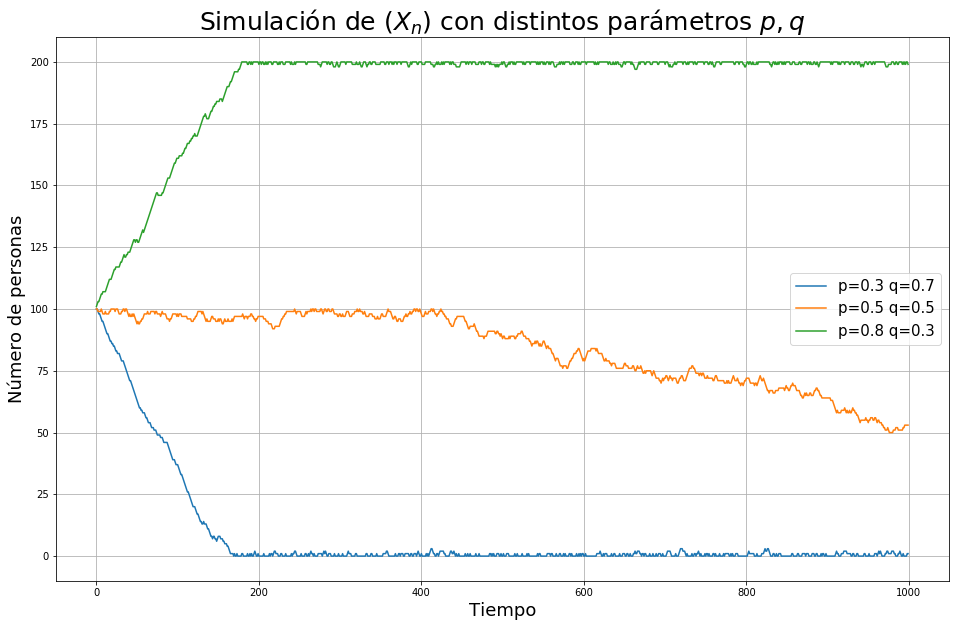

In [25]:
PQ=[(0.3,0.7),(0.5,0.5),(0.8,0.3)] #Lista de distintos parámetros p,q
ListaN=[15,100,200] #Lista de distinas capacidades máximas 
#Gráfico
plt.figure(figsize=(16,10))
x=np.arange(0,n)
for i in range(3):
    (p,q)=PQ[i]
    N=ListaN[i]
    modelo=colas(100,p,q,n,N)
    plt.plot(x,modelo,'-',label="p="+str(p)+" q="+str(q))
plt.title("Simulación de $(X_n)$ con distintos parámetros $p,q$",fontsize=25)
plt.xlabel("Tiempo",fontsize=18)
plt.ylabel("Número de personas",fontsize=18)
plt.legend(prop={"size":15})
plt.grid()
plt.show()

Es fácil observar que dependiendo de $p,q$ las trayectorias cambian notablemente, esto es lógico pensando que $p$ representa la probabilidad de que lleguen clientes, y $q$ de que sean atendidos y se vayan, por lo cual si $p>q$ la cola tenderá a hacerse más larga. Si $p<q$, la cola tenderá a irse a 0. Y por otro lado, si $p=q$ observamos que el comportamiento ronda siempre alrededor de la cantidad inicial de personas (100 en el caso de arriba).

### 3.

En esta parte del problema se eligen parámetros $p,q$ tales que $p<q$ junto con un valor fijo $N$ para luego estimar numéricamente la distribución invariante $\pi^N$. Para esto veremos 2 métodos:
1. Simular K cadenas de Markov (K grande) independientes en un tiempo T (grande), para luego obtener la medida empírica para las K trayectorias.
2. Simular una CM por un tiempo T (grande) y calcular las medidas ergódicas:
$\displaystyle \frac{1}{T}\cdot \sum_{k=1}^{T} 1_{X_k=i}, \hspace{5mm} i \in \{0,...,N\}$

In [26]:
#Elección de parámetros
(p,q)=(0.4,0.55) #p<q
N=20
(K,T)=(1000,10000)
# Función para el primer método
def med_empirica(mod):
    M=np.zeros(K)
    for i in range(K):
        M[i]=colas(500,p,q,T,N)[len(modelo)-1] 
    return ss.relfreq(M,numbins=N).frequency
# Función para el segundo método
modelo=colas(500,p,q,T,N)
def med_ergodica(mod):
    E=np.zeros(N)
    for i in range(N):
        s=0
        for j in range(T):
            if modelo[j]==i:
                s+=1
        E[i]=s/T
    return E

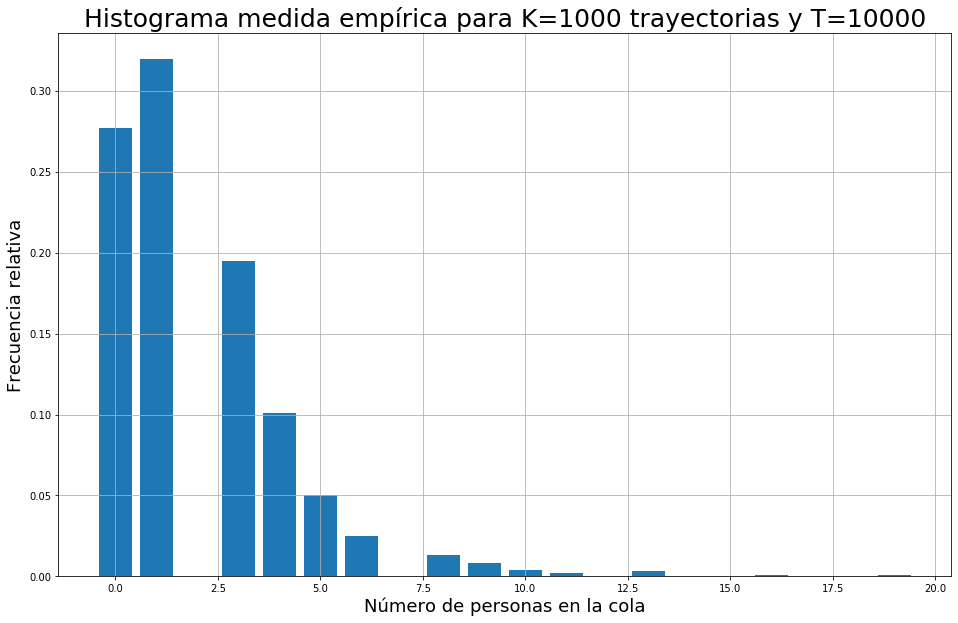

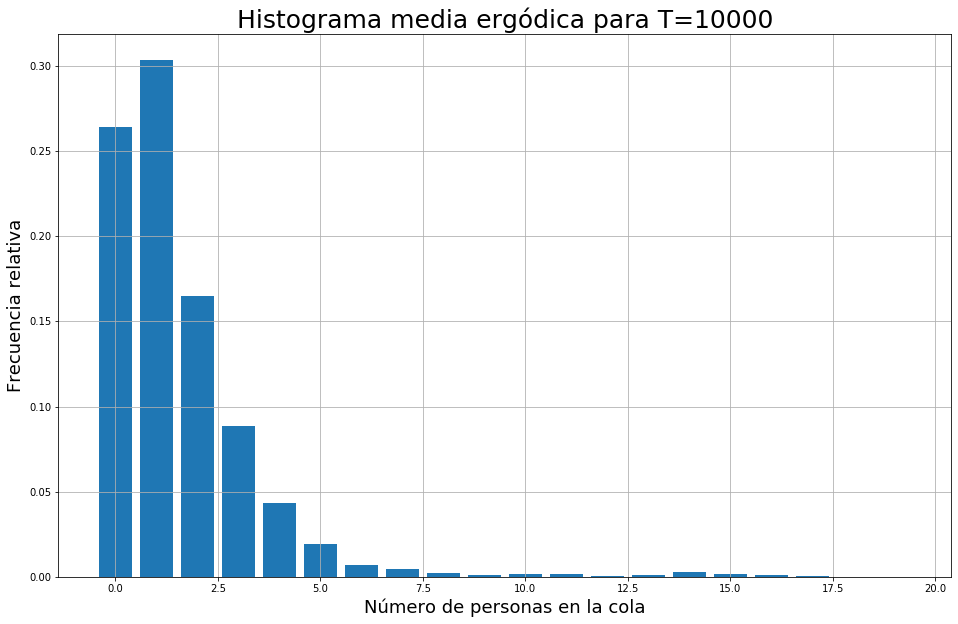

In [27]:
#Gráficos  --- Demora 1 min aproximadamante ---
modelo1=colas(0,p,q,n,N)
ejex=np.arange(0,N)
medidaEmp=med_empirica(modelo)
modelo2=colas(0,p,q,T,N)
medidaErg=med_ergodica(modelo)
plt.figure(figsize=(16,10))
plt.bar(ejex,medidaEmp)
plt.title("Histograma medida empírica para K=1000 trayectorias y T=10000",fontsize=25)
plt.xlabel("Número de personas en la cola",fontsize=18)
plt.ylabel("Frecuencia relativa",fontsize=18)
plt.grid()
plt.show()
plt.figure(figsize=(16,10))
plt.bar(ejex,medidaErg)
plt.title("Histograma media ergódica para T=10000",fontsize=25)
plt.xlabel("Número de personas en la cola",fontsize=18)
plt.ylabel("Frecuencia relativa",fontsize=18)
plt.grid()
plt.show()

En la figura anterior se puede apreciar el comportamiento geométrico que trae este modelamiento, esto para ambos métodos efectuados

A continuación se crea la distribución invariante $\pi$ dada en el enunciado para el caso $p<q$ junto con una función que permita calcular la distancia en variación total.

In [28]:
# Creación de pi (distribución invariante)
(N,K,T)=(20,1000,1000)
(p,q)=(0.4,0.55)
distr_inv=np.zeros(N)
for i in range(N):
    if i>0:
        distr_inv[i]=(((p*(1-q))/(q*(1-p)))**i)*(q-p)/(q*(1-q))
    else:
        distr_inv[0]=(q-p)/q
def variacion_total(medida,p,q):
    v=0
    for i in range(N):
        v=v+np.abs(distr_inv[i]-medida[i])
    return v

In [29]:
# Comparación de métodos
vt1=variacion_total(medidaEmp,p,q)
vt2=variacion_total(medidaErg,p,q)
print("Medida de variación total del método empírico: ",vt1)
print("Medida de variación total del método ergódico: ",vt2)

Medida de variación total del método empírico:  0.4004976831327295
Medida de variación total del método ergódico:  0.10679062529026481


### Conclusión

En esta parte del laboratorio se puedo apreciar un poco mejor la implementación práctica y simulable de las cadenas de Markov inicialmente presentadas en la pregunta 2.  
Se pudo simular de manera realista un problema de teoría de colas, pensando en una restricción acorde de un número máximo de clientes. Por último, evaluando y comparando los 2 métodos vistos en la parte 3, se puede concluir que, debido a la distancia en variación total, simular una CM por un tiempo T es mejor para estimar numéricamente la distribución $\pi^N$.
